In [31]:
import zsl_noma_achievable_rate
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [32]:
# 基本参数
M1 = 4
M2 = 64

K1 = int(np.log2(M1))
K2 = int(np.log2(M2))

M = M1*M2
K = int(np.log2(M))

SNR1_dB = 5
SNR2_dB = 15

SNR1 = 10**(.1*SNR1_dB)
SNR2 = 10**(.1*SNR2_dB)

In [33]:
symbols_composite_QAM, labels_composite_QAM = zsl_noma_achievable_rate.grayQAM(M, True)

In [34]:
symbols_CL, labels_CL = zsl_noma_achievable_rate.grayQAM(M1, True) # QPSK
symbols_EL_QAM, labels_EL_QAM = zsl_noma_achievable_rate.grayQAM(M2, True)

In [35]:
delta = 0.05
alpha_vec = np.arange(0, 1+delta, delta)

Rbc_QAM_type1 = np.zeros(len(alpha_vec))
Ruc_QAM_type1 = np.zeros(len(alpha_vec))

Rbc_QAM_type2 = np.zeros(len(alpha_vec))
Ruc_QAM_type2 = np.zeros(len(alpha_vec))

In [36]:
MUSTtype = 1
for i in tqdm(range(len(alpha_vec))):
    
    alpha = alpha_vec[i]
    symbols_QAM, labels_QAM = zsl_noma_achievable_rate.MUST(symbols_CL, symbols_EL_QAM, labels_CL, labels_EL_QAM, 1-alpha, alpha, MUSTtype)

    tmp1_QAM = zsl_noma_achievable_rate.awgn(symbols_QAM*np.sqrt(SNR1), labels_QAM, K1)

    Rbc_QAM_type1[i] = tmp1_QAM.sum()
    
    tmp2_QAM = zsl_noma_achievable_rate.awgn(symbols_QAM*np.sqrt(SNR2), labels_QAM, -K2)

    Ruc_QAM_type1[i] = tmp2_QAM.sum()

100%|██████████| 21/21 [00:03<00:00,  6.21it/s]


In [37]:
MUSTtype = 2
for i in tqdm(range(len(alpha_vec))):
    
    alpha = alpha_vec[i]
    symbols_QAM, labels_QAM = zsl_noma_achievable_rate.MUST(symbols_CL, symbols_EL_QAM, labels_CL, labels_EL_QAM, 1-alpha, alpha, MUSTtype)

    tmp1_QAM = zsl_noma_achievable_rate.awgn(symbols_QAM*np.sqrt(SNR1), labels_QAM, K1)

    Rbc_QAM_type2[i] = tmp1_QAM.sum()
    
    tmp2_QAM = zsl_noma_achievable_rate.awgn(symbols_QAM*np.sqrt(SNR2), labels_QAM, -K2)

    Ruc_QAM_type2[i] = tmp2_QAM.sum()

100%|██████████| 21/21 [00:02<00:00,  7.50it/s]


In [38]:
R1_MSD_CM = np.zeros(alpha_vec.size)
R2_MSD_CM = np.zeros(alpha_vec.size)
R1_MSD_BICM = np.zeros(alpha_vec.size)
R2_MSD_BICM = np.zeros(alpha_vec.size)
symbols_CL, labels_CL = zsl_noma_achievable_rate.grayQAM(M1, True)
symbols_EL, labels_EL = zsl_noma_achievable_rate.grayQAM(M2, True)

for i in tqdm(range(alpha_vec.size)):  
    alpha = alpha_vec[i]
    r1, r2 = zsl_noma_achievable_rate.getMSDCMRatePair(symbols_CL, symbols_EL, SNR1, SNR2, alpha)
    R1_MSD_CM[i] = r1
    R2_MSD_CM[i] = r2

    r1, r2 = zsl_noma_achievable_rate.getMSDBICMRatePair(symbols_CL, labels_CL, symbols_EL, labels_EL, SNR1, SNR2, alpha)
    R1_MSD_BICM[i] = r1
    R2_MSD_BICM[i] = r2

100%|██████████| 21/21 [00:01<00:00, 11.92it/s]


In [39]:
# Gaussian inputs
R1_thy = np.zeros(len(alpha_vec))
R2_thy = np.zeros(len(alpha_vec))

for i in range(len(alpha_vec)):
    
    r1, r2 = zsl_noma_achievable_rate.getTheoreticRate(SNR1_dB, SNR2_dB, alpha_vec[i])
    R1_thy[i] = r1
    R2_thy[i] = r2

In [40]:
# BDM / MUST-Type3
BDM_bit_capacity_1 = zsl_noma_achievable_rate.awgn(symbols_composite_QAM*np.sqrt(SNR1), labels_composite_QAM)
BDM_bit_capacity_2 = zsl_noma_achievable_rate.awgn(symbols_composite_QAM*np.sqrt(SNR2), labels_composite_QAM)
L = int(1e3) # 参与BDM的符号数（控制粒度）
total_bits = L*K

R1_BDM = np.zeros(total_bits+1)
R2_BDM = np.zeros(total_bits+1)

R1_BDM[0] = 0
R2_BDM[0] = sum(BDM_bit_capacity_2)*L

for i in range(total_bits):
    
    idx = zsl_noma_achievable_rate.decision(i, L, BDM_bit_capacity_1, BDM_bit_capacity_2, "good")
    R2_BDM[i+1] = R2_BDM[i]-BDM_bit_capacity_2[idx]
    R1_BDM[i+1] = R1_BDM[i]+BDM_bit_capacity_1[idx]
        
R1_BDM /= L
R2_BDM /= L

# TDM
R1_TDM = [0, R1_BDM[-1]]
R2_TDM = [R2_BDM[0], 0]

(0.0, 5.1)

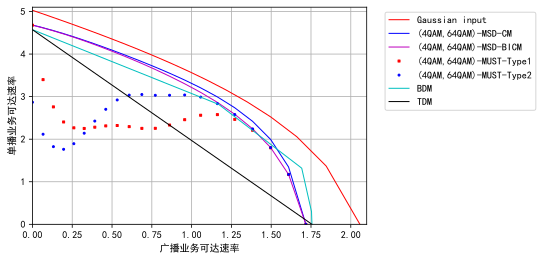

In [47]:
fig = plt.figure()

#解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False 
plt.grid()

plt.plot(R1_thy, R2_thy, linewidth=1.0, linestyle='-', color='r', label="Gaussian input")
plt.plot(R1_MSD_CM, R2_MSD_CM, linewidth=1.0, linestyle='-', color='b', label="(4QAM,64QAM)-MSD-CM")
plt.plot(R1_MSD_BICM, R2_MSD_BICM, linewidth=1.0, linestyle='-', color='m', label="(4QAM,64QAM)-MSD-BICM")

plt.plot(Rbc_QAM_type1, Ruc_QAM_type1, linewidth=1.0, marker='s', markersize=2, linestyle='none', color='r', label="(4QAM,64QAM)-MUST-Type1")
plt.plot(Rbc_QAM_type2, Ruc_QAM_type2, linewidth=1.0, marker='o', markersize=2, linestyle='none', color='b', label="(4QAM,64QAM)-MUST-Type2")

plt.plot(R1_BDM, R2_BDM, linewidth=1.0, linestyle='-', color='c', label="BDM")
plt.plot(R1_TDM, R2_TDM, linewidth=1.0, linestyle='-', color='k', label="TDM")

plt.xlabel("广播业务可达速率")
plt.ylabel("单播业务可达速率")

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.xlim([0, 2.1])
plt.ylim(0, 5.1)